In [1]:
# imports
import numpy as np
import torch
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from tqdm import tqdm_notebook as tqdm
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")

In [2]:
# data tools
def read_glass():
    all_csv = np.genfromtxt('glass.txt', delimiter=',')
    attributes = np.array([
        np.array(row[:-1])
        for row in all_csv
    ])
    labels = np.array([
        row[-1]
        for row in all_csv
    ])
    return attributes, labels


def read_iris():
    all_csv = pd.read_csv("iris.txt", header=None).values
    attributes = np.array([
        np.array(row[:-1])
        for row in all_csv
    ])
    labels = np.array([
        row[-1]
        for row in all_csv
    ])
    return attributes, labels


def read_wine():
    all_csv = np.genfromtxt('wine.txt', delimiter=',')
    attributes = np.array([
        np.array(row[1:])
        for row in all_csv
    ])
    labels = np.array([
        row[0]
        for row in all_csv
    ])
    return attributes, labels


def get_label_converters(labels):
    def prepare_two_array_dictionary(keys, values):
        return dict(zip(keys, values))
    unique_labels = np.unique(labels)
    indexes = np.array(range(unique_labels.shape[0]))
    return prepare_two_array_dictionary(unique_labels, indexes), prepare_two_array_dictionary(indexes, unique_labels)


In [3]:
# declare data
input_x, input_y = read_glass()
label_to_numeric, numeric_to_label = get_label_converters(input_y)
# normalized_x = preprocessing.normalize(input_x) to psuło całe zadanie
numeric_y = np.array([label_to_numeric[it] for it in input_y])
X_train, X_test, y_train, y_test = train_test_split(input_x, numeric_y, test_size=0.1)


In [4]:
# bayes tools
def get_labels_probability(labels):
    labels_count = labels.shape[0]
    unique, counts = np.unique(labels, return_counts=True)
    return np.array([it / labels_count for it in counts])


def get_predict_probability(attributes_to_predict, mi_matrix, sigma_matrix, label_probability):
    def get_single_attribute_value(att_it, lab_it):
        sigma = sigma_matrix[lab_it][att_it].detach().numpy()
        # sigma can't be 0, se then will be nan in results, in this case better is very small value
        if sigma == 0:
            sigma = 0.000001
        mi = mi_matrix[lab_it][att_it].detach().numpy()
        attribute = attributes_to_predict[att_it]
        exponent = np.exp(-(np.power(attribute - mi, 2) / (2 * np.power(sigma, 2))))
        if math.isnan((1 / (np.sqrt(2 * np.pi) * sigma)) * exponent):
            print('nan result', exponent, (1 / (np.sqrt(2 * np.pi) * sigma)))
            print('next', sigma, mi, attribute)
        return (1 / (np.sqrt(2 * np.pi) * sigma)) * exponent + 0.001

    labels_count = mi_matrix.shape[0]
    attributes_count = mi_matrix.shape[1]

    return np.array([
        label_probability[label_it] * np.array([
            get_single_attribute_value(attribute_it, label_it)
            for attribute_it in range(attributes_count)
        ]).prod()
        for label_it in range(labels_count)
    ])


def get_predict_probability_for_all(attributes_to_predict, mi_matrix, sigma_matrix, label_probability):
    return np.array([
        get_predict_probability(it, mi_matrix, sigma_matrix, label_probability)
        for it in attributes_to_predict
    ])


def get_apriori_attributes_distribution(x_data, y_data):
    def attributes_aggregate(data_matrix, aggregator):
        return np.array([
            [aggregator(attribute_values) for attribute_values in np.transpose(label_data)]
            for label_data in data_matrix
        ])

    unique_labels = np.unique(y_data)
    attributes_by_labels = np.array([
        [data_row[0] for data_row in zip(x_data, y_data) if data_row[1] == label]
        for label in unique_labels
    ])
    mi_matrix = attributes_aggregate(attributes_by_labels, lambda x: np.mean(x))
    sigma_matrix = attributes_aggregate(attributes_by_labels, lambda x: np.std(x))
    return mi_matrix, sigma_matrix


In [5]:
# model definition
def model(x_data, y_data):
    # calculate dimension
    attributes_count = x_data.shape[1]
    labels_count = np.unique(y_data).shape[0]
    model_shape = (labels_count, attributes_count)
    
    # calculate apriori
    mi_apriori, sigma_apriori = get_apriori_attributes_distribution(x_data, y_data)

    # prepared sampled mi and sigma matrix
    prior_scale = torch.ones(model_shape) * 0.001
    mi_matrix = pyro.sample('mi_matrix', Normal(loc=torch.from_numpy(mi_apriori).float(), scale=prior_scale))
    sigma_matrix = pyro.sample('sigma_matrix', Normal(loc=torch.from_numpy(sigma_apriori).float(), scale=prior_scale))

    # calculate labels probability (used in bayes)
    labels_probability = get_labels_probability(y_data)

    # calculate bayes probabilities
    predict_probabilities = torch.Tensor(get_predict_probability_for_all(x_data, mi_matrix,
                                                                         sigma_matrix, labels_probability))
    # sample and observe
    pyro.sample("obs", Categorical(logits=predict_probabilities), obs=torch.tensor(y_data).float())


In [6]:
# guide definition
soft_plus = torch.nn.Softplus()


def guide(x_data, y_data):
    # calculate dimension
    attributes_count = x_data.shape[1]
    labels_count = np.unique(y_data).shape[0]
    model_shape = (labels_count, attributes_count)

    # calculate mi
    mi_matrix_mi = torch.rand(model_shape)
    mi_matrix_sigma = torch.rand(model_shape)
    mi_matrix_mi_param = pyro.param("mi_matrix_mi", mi_matrix_mi)
    mi_matrix_sigma_param = soft_plus(pyro.param("mi_matrix_sigma", mi_matrix_sigma))
    mi_matrix_distribution = Normal(loc=mi_matrix_mi_param, scale=mi_matrix_sigma_param)

    # calculate sigma
    sigma_matrix_mi = torch.rand(model_shape)
    sigma_matrix_sigma = torch.rand(model_shape)
    sigma_matrix_mi_param = pyro.param("sigma_matrix_mi", sigma_matrix_mi)
    sigma_matrix_sigma_param = soft_plus(pyro.param("sigma_matrix_sigma", sigma_matrix_sigma))
    sigma_matrix_distribution = Normal(loc=sigma_matrix_mi_param, scale=sigma_matrix_sigma_param)

    # sample mi and sigma matrix
    return pyro.sample('mi_matrix', mi_matrix_distribution), pyro.sample('sigma_matrix', sigma_matrix_distribution)


In [7]:
# train model definition
losses, alpha_values, beta_values = [], [], []


def train():
    pyro.clear_param_store()
    num_iterations = 100000
    optim = pyro.optim.Adam({"lr": 0.01})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    t = tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(X_train, y_train)
        t.set_postfix(loss=loss)
        losses.append(loss)
    return model, svi


In [ ]:
# run model train
model, svi = train()


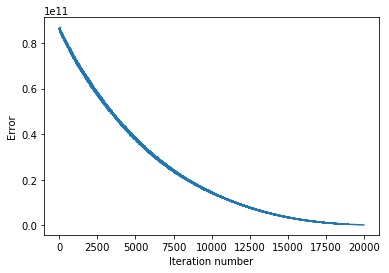

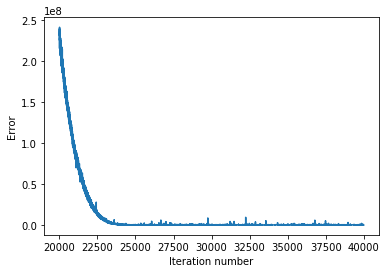

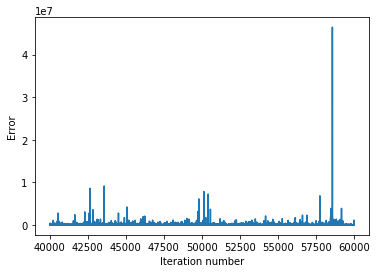

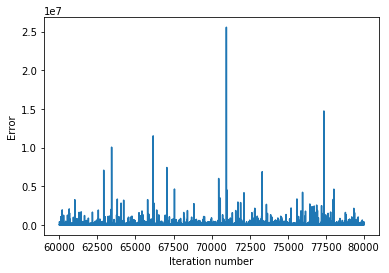

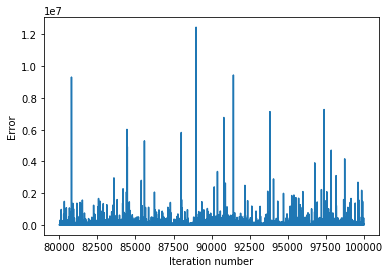

In [18]:
def show_ELBO_chart(from_iteration, to_iteration):
    df = pd.DataFrame({'$a':np.arange(len(losses))[from_iteration:to_iteration] + 1, 
                       '$b': losses[from_iteration:to_iteration]})
    df.columns = ['Iteration number', 'Error']
    sns.lineplot(x='Iteration number', y='Error', data=df)
    plt.show()


show_ELBO_chart(0, 20000)
show_ELBO_chart(20000, 40000)
show_ELBO_chart(40000, 60000)
show_ELBO_chart(60000, 80000)
show_ELBO_chart(80000, 100000)

In [14]:
# Watrości parametrów
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

mi_matrix_mi tensor([[ 3.4099e+01,  1.5160e+00,  1.3251e+01,  3.5635e+00,  1.1586e+00,
          7.2606e+01,  4.4713e-01,  8.7940e+00,  1.2081e-02,  6.2271e-02],
        [ 1.0945e+02,  1.5191e+00,  1.3104e+01,  3.0483e+00,  1.3797e+00,
          7.2678e+01,  5.2443e-01,  9.0262e+00,  1.0126e-02,  7.8018e-02],
        [ 1.5453e+02,  1.5178e+00,  1.3392e+01,  3.5368e+00,  1.2213e+00,
          7.2470e+01,  4.1509e-01,  8.7256e+00,  9.5484e-03,  6.6120e-02],
        [ 1.7091e+02,  1.5209e+00,  1.2837e+01,  4.9898e-01,  1.9439e+00,
          7.2545e+01,  1.5398e+00,  1.0392e+01,  2.0767e-02,  7.3502e-02],
        [ 1.8100e+02,  1.5187e+00,  1.4646e+01,  1.3035e+00,  1.3681e+00,
          7.3206e+01,  6.3999e-04,  9.3558e+00, -3.6641e-03,  1.1066e-03],
        [ 2.0011e+02,  1.5173e+00,  1.4460e+01,  5.5702e-01,  2.1067e+00,
          7.2958e+01,  3.3520e-01,  8.4586e+00,  1.0495e+00,  1.3385e-02]],
       requires_grad=True)
mi_matrix_sigma tensor([[-6.9237, -6.7898, -6.8438, -6.8135, -6.8

In [15]:
# Test predykcji dla wyuczonych parametrów
mu,sigma=guide(X_train,y_train)
pred = get_predict_probability_for_all(X_test,mu,sigma, get_labels_probability(y_train))
predicted_labels=[np.argmax(pred_it) for pred_it in pred]
accuracy=accuracy_score(y_test, predicted_labels)
print('Accuracy dla wyuczonych parametrów Naive Bayes opartego o rozkład Gaussa:', 100*accuracy, "%")

Accuracy dla wyuczonych parametrów Naive Bayes opartego o rozkład Gaussa: 68.18181818181817 %


In [16]:
# Test dla klasycznego Bayesa
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy dla klasycznego Naive Bayes opartego o rozkład Gaussa:', accuracy_score(y_test, y_pred) * 100, "%")

Accuracy dla klasycznego Naive Bayes opartego o rozkład Gaussa: 86.36363636363636 %
